In [373]:
# build AST Tree and compute the zss edit distance between different ASTs

import json
import numpy as np
import zss
from os import listdir
from os.path import splitext
from itertools import imap, chain
from operator import sub
ast_path = "/data/hoc18/ASTs/"
ast_dist_file = "/Users/jiangbo/ProgameTrajectory/hoc18/ast_dist_zss"
tjmat =("/Users/jiangbo/ProgameTrajectory/hoc18/tj_matrix18.csv")
path_clean =("/Users/jiangbo/ProgameTrajectory/hoc18/path18_clean.csv")
path_dist =("/Users/jiangbo/ProgameTrajectory/hoc18/tj_dist18.csv")
ast_dist_npy = "/Users/jiangbo/ProgameTrajectory/hoc18/ast_dist_zss.npy"


# define the tree structure that can be inputed in to zss
class Node(object):
    def __init__(self, id=None, label=None,level=0):
        self.id = id
        self.label = label
        self.level = level
        self.children = []

    def __repr__(self):        
        return '\n{indent}Node({id},{label},{children})'.format(
                                         indent = self.level*'\t', 
                                         id = self.id,
                                         label = self.label,
                                         children = repr(self.children))
    def add_child(self, child):
        self.children.append(child)    

def tree_builder(obj, level=0):
    node = Node(id=obj['id'], label=obj['type'], level=level)
    for child in obj.get('children',[]):
        node.add_child(tree_builder(child, level=level+1))
    return node

def load_json(ast_no):
    with open(ast_path+"%s.json"%ast_no) as f:
        return json.load(f)

# the ast file are named using number from 1 to 79553, but some files are missing. To implement cycle
# we need first to get all the ast json file name without .json suffix
def get_ast_lists (ast_path):
    #listdir(ast_path)
    ast_lists =[]
    for data_file in sorted(listdir(ast_path)):
        ast_lists.append (splitext(data_file)[0]) # get the name of each ast file without suffix
    ast_lists = np.sort(map(int, ast_lists)) #convert list to sorted numeric
    return ast_lists

# find out which ast files are missed
def detect_missing_ast (ast_lists):
    a = ast_lists
    miss_asts = list(chain.from_iterable((a[i] + d for d in xrange(1, diff))
                        for i, diff in enumerate(imap(sub, a[1:], a))
                        if diff > 1))
    return miss_asts 

def delete_paths_contain_missing_ast (ast_lists):
    miss_ast = detect_missing_ast (ast_lists)  # missing ast files
    with open(tjmat,'r') as f:
        mylist = csv.reader(f,delimiter=',') 
        for index,line in enumerate(mylist):
            tj_ast = np.array(line)
            tj_ast = list(filter(None,tj_ast))  #skip empty cell in each line
            tj_ast = map(int,tj_ast)
            if (bool(list(set(tj_ast) & set(miss_ast)))== False) & (set(tj_ast).issubset(set(ast_lists))):  # if there is no intersections, keep this tj_ast
                with open(path_clean,'a') as fout:
                    csv_out = csv.writer(fout, delimiter=',')
                    csv_out.writerow(tj_ast)

def astfile_match_astlist (astfile_nos, ast_lists):
    astlen = len(astfile_nos)
    pos = np.zeros(astlen)
    for i in range(astlen):
        pos[i] = np.argwhere(ast_lists == astfile_nos[i])
    return pos.astype(int)

# compute the zss distance between the Top 'ast_nos' ASTs in ast_path
def ast_distance(ast_path,pct_ast):
    ast_lists = get_ast_lists (ast_path)
    ast_len = len(ast_lists)
    print 'Number of all ASTs is:%d'%ast_len
    
    ast_nos = np.int(pct_ast*len(ast_lists))
    print 'Number of sampled ASTs is:%d'% ast_nos
    
    dist = np.zeros((ast_nos,ast_nos))
    for i in xrange(ast_nos):
        for j in xrange(ast_nos):
            if i < j:
                t1 = load_json(ast_lists[i])
                t2 = load_json(ast_lists[j])
                dist[i,j] = zss.simple_distance(tree_builder(t1),tree_builder(t2))
            elif i > j:
                dist[i,j]=dist[j,i]
            else:
                dist[i,j]=0                   
    return dist

def approaching_indx(ast_path):
    ast_lists = get_ast_lists (ast_path)
    ast_nos = len(ast_lists)
    print 'Number of ASTs is:%d'% ast_nos
    
    dist = np.zeros((ast_nos))
    t0 = load_json(ast_lists[0])
    for i in xrange(ast_nos):
        t1 = load_json(ast_lists[i])
        dist[i] = zss.simple_distance(tree_builder(t1),tree_builder(t0))                 
    np.save(ast_dist_file,dist)

# convert raw path to approaching indicator path,clear outp_utfile before you run this code
def rawpath_to_aipath(input_file,ai_list,output_file):
    ast_dist = ai_list
    with open(input_file,'r') as f:
        mylist = csv.reader(f,delimiter=',') 
        for index,line in enumerate(mylist):
            single_path = np.array(line)
            single_path = list(filter(None,single_path))  #skip empty cell in each line
            single_path = map(int, single_path)          # map sting list to int list 
            path_mapped = astfile_match_astlist (single_path, ast_lists)
            path = ast_dist[path_mapped]
            with open(output_file,'a') as fout:
                csv_out = csv.writer(fout, delimiter=',')
                csv_out.writerow(path)
                

In [376]:
missing_ast =("/Users/jiangbo/ProgameTrajectory/hoc18/missing_ast")
ast_dist = np.load(ast_dist_npy)
ast_lists = get_ast_lists (ast_path)
miss_ast = detect_missing_ast (ast_lists)
np.save(missing_ast, miss_ast)

In [13]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np
import csv
import pandas as pd
tj_dist_dtw =("/Users/jiangbo/ProgameTrajectory/hoc18/tj_dist_dtw")
tjdist =("/Users/jiangbo/ProgameTrajectory/hoc18/tj_dist18.csv")
select_path = "/Users/jiangbo/ProgameTrajectory/hoc18/randomly_selected_path_id"
sample_size = 20000
distances =np.zeros([sample_size,sample_size])

with open(tjdist,'r') as f:
    mylist = csv.reader(f,delimiter=',',quoting=csv.QUOTE_NONNUMERIC)
    mylist =list(mylist)
    pmt = np.random.permutation(len(mylist))
    randomly_selected_path_id =pmt[0:sample_size]
    newlist = [mylist[k] for k in pmt[0:sample_size]]
for i,x in enumerate(newlist):
    for j,y in enumerate(newlist):
        if i ==j:
            distances[i,j]=0
        elif i < j:
            distances[i,j],pw = fastdtw(x,y,dist=euclidean)
        else:
            distances[i,j]=distances[j,i]
#save data            
np.save(tj_dist_dtw,distances)
np.save(select_path,randomly_selected_path_id)


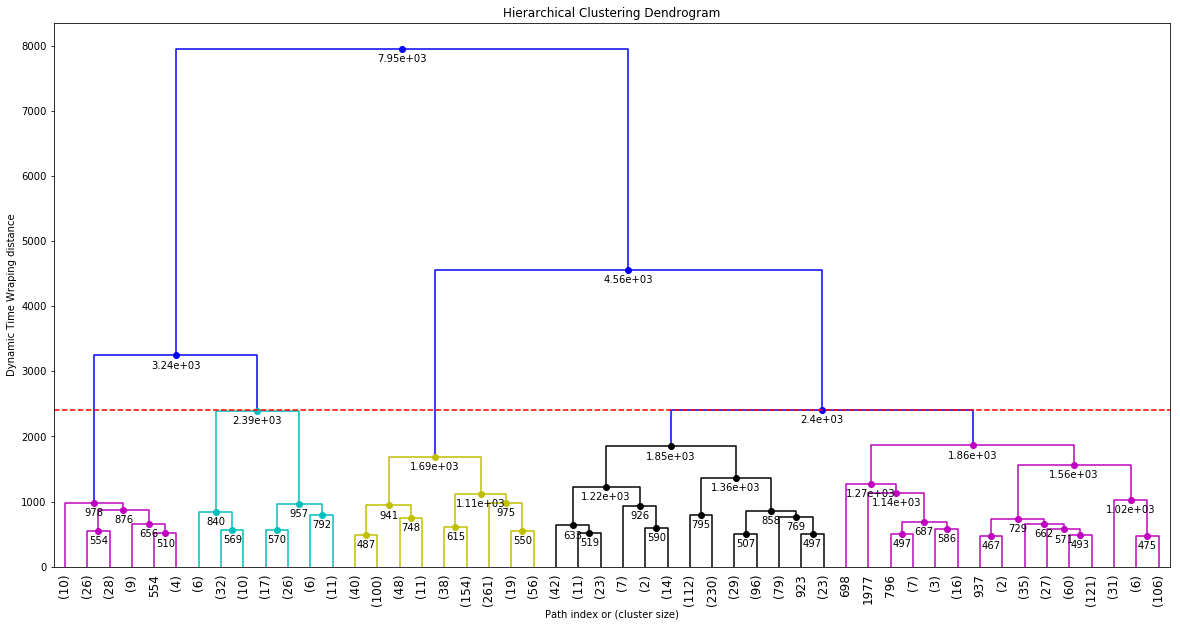

In [7]:
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from fastcluster import linkage
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

ast_dist= np.load("/Users/jiangbo/ProgameTrajectory/hoc18/tj_dist_dtw.npy")

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,N,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage


def fancy_dendrogram(*args, **kwargs):
    # show different clors
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)
    # show the distance between each cluster
    if not kwargs.get('no_plot', False):
        plt.xlabel('Path index or (cluster size)')
        plt.ylabel('Dynamic Time Wraping distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='r',linestyle='--')
    return ddata

# methods = ["ward","average","complete"]
methods = ["ward"]
#ast_dist =np.load(ast_dist_file+'.npy')
N =ast_dist.shape[0]
for method in methods:
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(ast_dist,N,method)
    
    
plt.figure(figsize=(20,10))
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.title('Hierarchical Clustering Dendrogram')
dn = fancy_dendrogram(res_linkage,leaf_rotation=90,leaf_font_size=12,max_d=2400,
               truncate_mode='lastp',  # show only the last p merged clusters
               p=50,  # show only the last p merged clusters
               )
# plt.savefig('/Users/jiangbo/ProgameTrajectory/hoc18/figures/Dendrogram.eps', format='eps', dpi=1000)
plt.show()

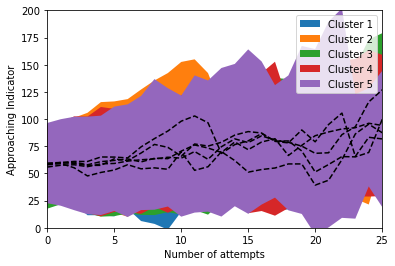

In [23]:
from scipy.cluster.hierarchy import fcluster
import csv
tj_dist =("/Users/jiangbo/ProgameTrajectory/hoc18/tj_dist18.csv")
def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output_mean = []
    output_std = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output_mean.append(np.nanmean(temp))
        output_std.append(np.nanstd(temp))
    return output_mean,output_std

max_d =2400
clusters = fcluster(res_linkage, max_d, criterion='distance')
labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
for i in xrange(5):
    idex = np.argwhere(clusters==i+1)
    with open(tj_dist,'r') as f:
        mylist = csv.reader(f,delimiter=',',quoting=csv.QUOTE_NONNUMERIC)
        mylist =list(mylist)
        cluster = randomly_selected_path_id[idex]
        cluster = cluster.reshape(-1)
        newlist = [mylist[k] for k in cluster]
        # convert newlist (list of list) to array
        y=np.array([np.array(xi) for xi in newlist])
        path_mean,path_std = avgNestedLists(y)
        
        pm = np.asarray(path_mean)
        ps = np.asarray(path_std)
        y_bot=[]
        y_top=[]
        y_med=[]
        for k in range(len(ps)):
            if ps[k]>0:
                y_bot.append(pm[k]-ps[k])
                y_top.append(pm[k]+ps[k])
                y_med.append(pm[k])
        #plt.errorbar(xx,path_mean,yerr=path_std,fmt='-o')
        xx=np.arange(len(y_med))
        plt.plot(xx, y_med, 'k--')
        plt.fill_between(xx, y_bot,y_top,label=labels[i])
        plt.xlim(0, 25)
        plt.ylim(0, 200)
plt.legend(loc='upper right')
plt.xlabel('Number of attempts')
plt.ylabel('Approaching Indicator')
#plt.savefig('/Users/jiangbo/ProgameTrajectory/hoc18/figures/PathClusters.eps', format='eps', dpi=1000)
plt.show()